<a href="https://colab.research.google.com/github/alansshots/federated-learning-institute-project/blob/main/Straggler_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 846.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [3]:
!pip install torch torchvision


--- Round 1/7 ---
Selected clients this round: [0, 1, 2]
Client 0 training time: 1.15 seconds
Client 1 timed out
Client 1 training time: 3.11 seconds
Client 2 training time: 1.05 seconds
2 out of 5 clients participated.
Accuracy: 0.2618, F1 Score: 0.2130, Loss: 2.2160

--- Round 2/7 ---
Selected clients this round: [2, 0, 1]
Adaptive timeout for this round: 2.56 seconds
Client 2 timed out
Client 2 training time: 2.70 seconds
Client 0 training time: 1.03 seconds
Client 1 timed out
Client 1 training time: 2.60 seconds
1 out of 5 clients participated.
Accuracy: 0.4125, F1 Score: 0.3687, Loss: 2.0246

--- Round 3/7 ---
Selected clients this round: [0, 2, 1]
Adaptive timeout for this round: 2.84 seconds
Client 0 timed out
Client 0 training time: 2.94 seconds
Client 2 training time: 2.13 seconds
Client 1 training time: 1.03 seconds
2 out of 5 clients participated.
Accuracy: 0.6170, F1 Score: 0.5842, Loss: 1.8100

--- Round 4/7 ---
Selected clients this round: [0, 2, 1]
Adaptive timeout for 

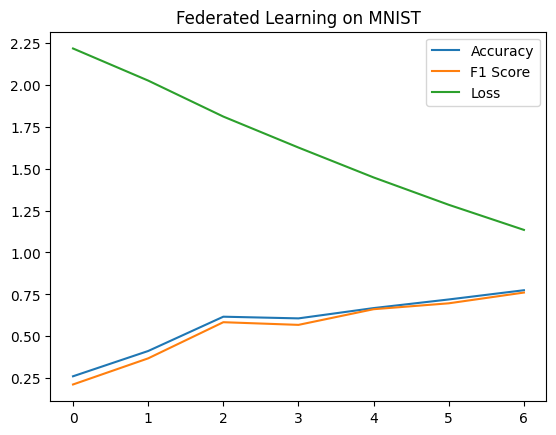

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchmetrics import Accuracy, F1Score
from torchvision import datasets, transforms
from copy import deepcopy
import numpy as np
import torchvision.models as models
from tqdm.autonotebook import tqdm
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import time
import random

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def resnet18(num_classes, **kwargs):
    original_model = models.resnet18(**kwargs)
    original_model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
    original_model.maxpool = nn.Identity()
    original_model.fc = nn.Linear(512, num_classes)
    return original_model

def uniform_allocation(Y, num_clients):
    indices = np.arange(len(Y))
    np.random.shuffle(indices)
    indices_split = np.array_split(indices, num_clients)
    return [list(idx) for idx in indices_split]

# Hyperparameters
num_clients = 5
batch_size = 64
global_epochs = 7
local_epochs = 1
learning_rate = 1e-2
loss_fn = nn.CrossEntropyLoss()
#timeout_seconds = 3

# Model
model = resnet18(10)
client_models = [deepcopy(model).to(device) for _ in range(num_clients)]
client_optims = [optim.SGD(cm.parameters(), lr=learning_rate) for cm in client_models]

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_dataset.data = train_dataset.data[:5000]
train_dataset.targets = train_dataset.targets[:5000]
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_subsets = uniform_allocation(train_dataset.targets, num_clients)
train_subsets = [torch.utils.data.Subset(train_dataset, indices) for indices in train_subsets]
train_subset_dataloaders = [DataLoader(ds, batch_size=batch_size, shuffle=True) for ds in train_subsets]
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def fed_avg(models):
    avg_model = deepcopy(models[0]).to(device)
    avg_state_dict = avg_model.state_dict()
    with torch.no_grad():
        for key in avg_state_dict.keys():
            if not avg_state_dict[key].dtype.is_floating_point:
                avg_state_dict[key].copy_(models[0].state_dict()[key])
                continue
            tmp = torch.zeros_like(avg_state_dict[key])
            for m in models:
                tmp += m.state_dict()[key]
            avg_state_dict[key].copy_(tmp / len(models))
    return avg_model

# client performance
client_times = [0.0 for _ in range(num_clients)]
client_counts = [0 for _ in range(num_clients)]

global_model = deepcopy(model).to(device)
acc_list, f1_list, loss_list = [], [], []

for round in range(global_epochs):
    print(f"\n--- Round {round+1}/{global_epochs} ---")
    participating_clients = []

    # average training time, select top 3 fastest clients
    avg_times = [
        client_times[i] / client_counts[i] if client_counts[i] > 0 else float('inf')
        for i in range(num_clients)
    ]
    selected_clients = sorted(range(num_clients), key=lambda i: avg_times[i])[:3]
    print(f"Selected clients this round: {selected_clients}")

        # Dynamically adjust timeout
    filtered_avg_times = [t for t in avg_times if t != float('inf')]
    if filtered_avg_times:
        estimated_round_time = np.percentile(filtered_avg_times, 75)
        timeout_seconds = estimated_round_time * 1.2
        print(f"Adaptive timeout for this round: {timeout_seconds:.2f} seconds")
    else:
        timeout_seconds = 3

    for i in selected_clients:
        client_models[i].load_state_dict(global_model.state_dict())
        client_models[i].train()
        start_time = time.time()

        # --- simulated straggler setup ---
        straggler_delay = random.uniform(1.5, 3) if random.random() < 0.4 else 0

        try:
            for epoch in range(local_epochs):
                for x, y in train_subset_dataloaders[i]:

                    # --- simulate slow clients ---
                    if straggler_delay:
                        time.sleep(straggler_delay / (local_epochs * len(train_subset_dataloaders[i])))

                    # --- timeout check ---
                    if time.time() - start_time > timeout_seconds:
                        raise TimeoutError(f"Client {i} timed out")

                    x, y = x.to(device), y.to(device)
                    client_optims[i].zero_grad()
                    y_pred = client_models[i](x)
                    loss = loss_fn(y_pred, y)
                    loss.backward()
                    client_optims[i].step()

            participating_clients.append(client_models[i])
        except TimeoutError as e:
            print(e)

        end_time = time.time()
        print(f"Client {i} training time: {end_time - start_time:.2f} seconds")
        client_times[i] += end_time - start_time
        client_counts[i] += 1

    print(f"{len(participating_clients)} out of {num_clients} clients participated.")

    if participating_clients:
        global_model.load_state_dict(fed_avg(participating_clients).state_dict())
    else:
        print("No clients completed training in this round.")

    global_model.eval()
    correct, total, test_loss = 0, 0, 0
    y_true, y_pred_all = [], []

    with torch.no_grad():
        for x, y in test_dataloader:
            x, y = x.to(device), y.to(device)
            logits = global_model(x)
            loss = loss_fn(logits, y)
            test_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
            y_true.extend(y.cpu().numpy())
            y_pred_all.extend(preds.cpu().numpy())

    acc = correct / total
    f1 = f1_score(y_true, y_pred_all, average='macro')
    acc_list.append(acc)
    f1_list.append(f1)
    loss_list.append(test_loss / len(test_dataloader))

    print(f"Accuracy: {acc:.4f}, F1 Score: {f1:.4f}, Loss: {loss_list[-1]:.4f}")

plt.plot(acc_list, label="Accuracy")
plt.plot(f1_list, label="F1 Score")
plt.plot(loss_list, label="Loss")
plt.legend()
plt.title("Federated Learning on MNIST")
plt.show()
